Epoch 1/80


/var/folders/g6/grvwn5y16hnbc_vmrhqpzkmm0000gn/T/ipykernel_2967/277404062.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed["origemRacial"].replace(map_raca).astype(float)
/var/folders/g6/grvwn5y16hnbc_vmrhqpzkmm0000gn/T/ipykernel_2967/277404062.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed[col].replace(map_boolean).astype(float)
/var/folders/g6/grvwn5y16hnbc_vmrhqpzkmm0000gn/T/ipykernel_2967/277404062.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7078 - loss: 0.8537 - val_accuracy: 0.7097 - val_loss: 0.7980
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7673 - loss: 0.8382 - val_accuracy: 0.7097 - val_loss: 0.7920
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7095 - loss: 0.6854 - val_accuracy: 0.7097 - val_loss: 0.7839
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7183 - loss: 0.7957 - val_accuracy: 0.6774 - val_loss: 0.7811
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7345 - loss: 0.8807 - val_accuracy: 0.6774 - val_loss: 0.7815
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6788 - loss: 0.7992 - val_accuracy: 0.6452 - val_loss: 0.7782
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7352 - loss: 0.7970 - val_accuracy: 0.6452 - val_loss: 0.7694
Epoch 8/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6920 - loss: 0.7571 - val_accuracy: 0.6452 - val_loss: 0.7594
Epoch 9/80
8/8 ━━━

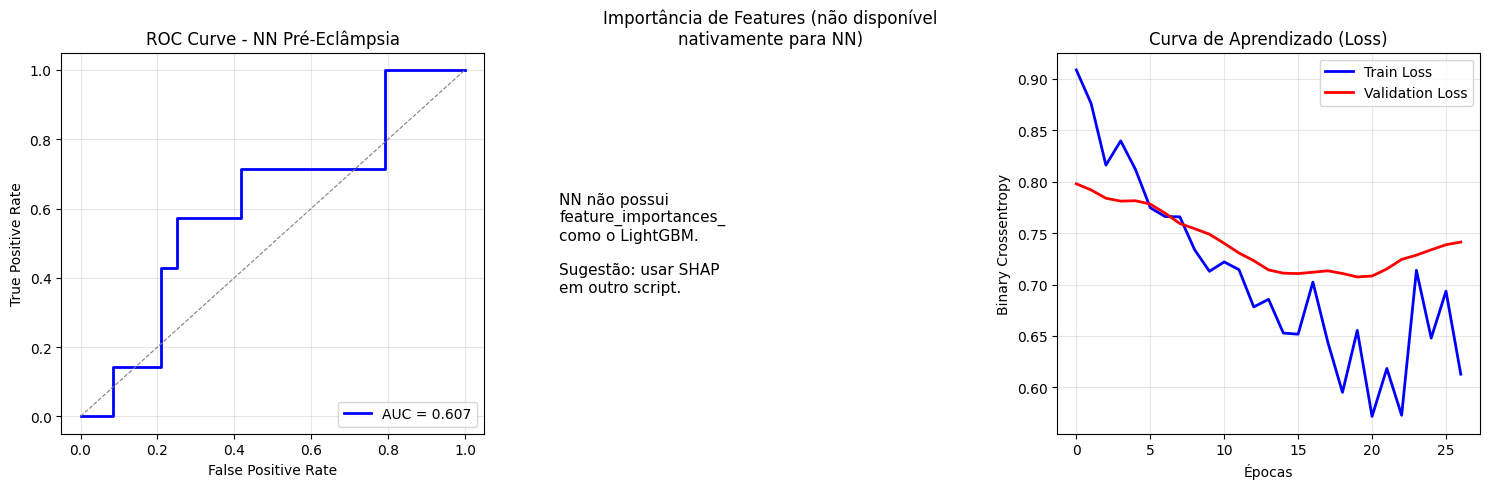

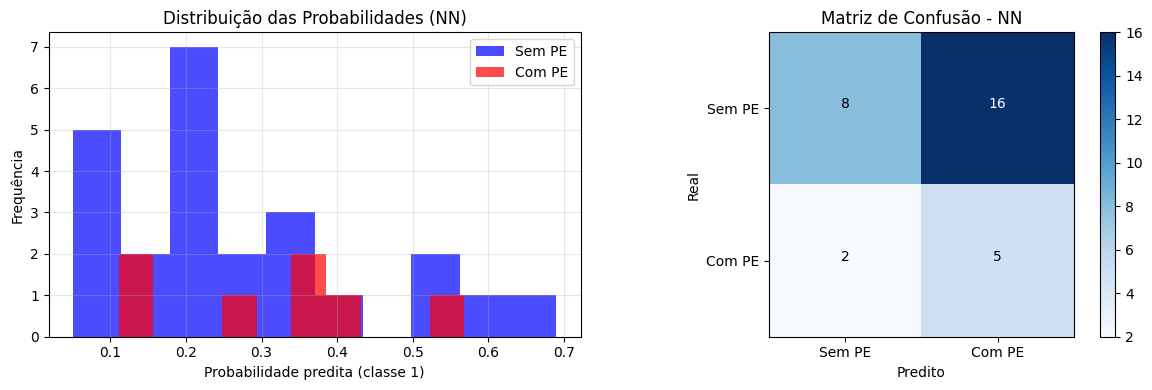


Threshold ~0.5 na ROC: 0.568
FPR nesse threshold: 0.083
TPR (sensibilidade) nesse threshold: 0.143


In [8]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# CONFIGURAÇÕES
# ------------------------------------------------------------------
DATA_PATH = "/Users/renanmoura/Documents/mestrado/PE-AI/data/dados.xlsx"
MODEL_DIR = "/Users/renanmoura/Documents/mestrado/PE-AI/models"
os.makedirs(MODEL_DIR, exist_ok=True)

TARGET_COL = "PreEclampsia"
INPUT_FEATURES = [
    "peso", "imc", "diabetes", "hipertensao", "pesoPrimeiroTrimestre",
    "origemRacial", "historicoFamiliarDiabetes", "mediaIP",
    "historiaObstetricaAnterior", "perdasGestacionais", "fuma",
    "idadeGestacional2", "idadeGestacionalCorrigida2", "pesoFetal",
    "percentilArteriaUterina", "percentilPeso", "temHipertensaoPreExistente",
    "temEndometriose", "temHipotireoidismo", "temIIC", "temTrombofilia",
    "temRetocolite", "temGastrite", "temOutraDoenca"
]

# ------------------------------------------------------------------
# PRÉ-PROCESSAMENTO
# ------------------------------------------------------------------
def preprocess_dataframe(df):
    map_raca = {"Branco": 1, "Pardo": 2, "Preto": 3}
    map_boolean = {
        "Sim": 1, "YES": 1, "SIM": 1, "TRUE": 1,
        "Nao": 0, "NAO": 0, "Não": 0, "NÃO": 0, "FALSE": 0
    }
    map_hist_diabetes = {
        "Não": 0, "NAO": 0, "NÃO": 0, "Nao": 0,
        "1º grau": 3, "1° GRAU": 3, "1 GRAU": 3,
        "2º grau": 2, "2° GRAU": 2, "2 GRAU": 2,
        "3º grau": 1, "3° GRAU": 1, "3 GRAU": 1
    }

    df_processed = df.copy()

    if "origemRacial" in df_processed.columns:
        df_processed["origemRacial"] = (
            df_processed["origemRacial"].replace(map_raca).astype(float)
        )

    cols_bool = ["diabetes", "fuma", "PreEclampsia", "hipertensao"]
    for col in cols_bool:
        if col in df_processed.columns:
            df_processed[col] = (
                df_processed[col].replace(map_boolean).astype(float)
            )

    if "historicoFamiliarDiabetes" in df_processed.columns:
        df_processed["historicoFamiliarDiabetes"] = (
            df_processed["historicoFamiliarDiabetes"]
            .astype(str).str.strip()
            .replace(map_hist_diabetes).astype(float)
        )

    if "historiaObstetricaAnterior" in df_processed.columns:
        df_processed["historiaObstetricaAnterior"] = pd.to_numeric(
            df_processed["historiaObstetricaAnterior"], errors="coerce"
        )
    if "perdasGestacionais" in df_processed.columns:
        df_processed["perdasGestacionais"] = pd.to_numeric(
            df_processed["perdasGestacionais"], errors="coerce"
        )

    doenca_cols = [
        "temHipertensaoPreExistente", "temEndometriose", "temHipotireoidismo",
        "temIIC", "temTrombofilia", "temRetocolite", "temGastrite", "temOutraDoenca"
    ]
    for col in doenca_cols:
        if col not in df_processed.columns:
            df_processed[col] = 0

    if "doencaPreExistente" in df_processed.columns:
        doenca_text = df_processed["doencaPreExistente"].astype(str).str.lower()
        df_processed["temHipertensaoPreExistente"] = doenca_text.str.contains("hipertens", na=False).astype(int)
        df_processed["temEndometriose"]           = doenca_text.str.contains("endometriose", na=False).astype(int)
        df_processed["temHipotireoidismo"]        = doenca_text.str.contains("hipotireoid", na=False).astype(int)
        df_processed["temTrombofilia"]            = doenca_text.str.contains("trombofilia", na=False).astype(int)
        df_processed["temGastrite"]               = doenca_text.str.contains("gastrite", na=False).astype(int)
        outras_condicoes = doenca_text.str.contains("diabetes|asma|depress|ansiedade|outra", na=False)
        df_processed["temOutraDoenca"] = (
            outras_condicoes &
            ~df_processed[[
                "temHipertensaoPreExistente", "temEndometriose",
                "temHipotireoidismo", "temTrombofilia", "temGastrite"
            ]].any(axis=1)
        ).astype(int)

    for col in INPUT_FEATURES:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors="coerce")
        else:
            df_processed[col] = 0.0

    for col in INPUT_FEATURES:
        df_processed[col] = df_processed[col].fillna(0)

    def aplicar_limites_realistas(X, feature_names):
        limites = {
            "peso": (40, 150),
            "imc": (15, 50),
            "pesoPrimeiroTrimestre": (35, 150),
            "pesoFetal": (0, 5000),
        }
        X = X.copy()
        for feat, (low, high) in limites.items():
            if feat in feature_names:
                X[feat] = X[feat].clip(lower=low, upper=high)
        return X

    df_processed[INPUT_FEATURES] = aplicar_limites_realistas(
        df_processed[INPUT_FEATURES], INPUT_FEATURES
    )

    df_processed = df_processed[~df_processed[TARGET_COL].isna()]
    df_processed[TARGET_COL] = df_processed[TARGET_COL].astype(int)
    return df_processed

# ------------------------------------------------------------------
# PIPELINE PRINCIPAL
# ------------------------------------------------------------------
df_raw = pd.read_excel(DATA_PATH)
if "PacienteId" not in df_raw.columns:
    raise ValueError("Coluna 'PacienteId' obrigatória.")

df_processed = preprocess_dataframe(df_raw)
df3 = df_processed.copy()
df3 = df3[~df3[TARGET_COL].isna()]
df3[TARGET_COL] = df3[TARGET_COL].astype(int)

X_all = df3[INPUT_FEATURES].copy()
y_all = df3[TARGET_COL].copy()
groups = df3["PacienteId"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X_all, y_all, groups=groups))
X_train = X_all.iloc[train_idx].reset_index(drop=True)
X_test  = X_all.iloc[test_idx].reset_index(drop=True)
y_train = y_all.iloc[train_idx].reset_index(drop=True)
y_test  = y_all.iloc[test_idx].reset_index(drop=True)

X_train_np = X_train.values.astype(float)
X_test_np  = X_test.values.astype(float)
y_train_np = y_train.values
y_test_np  = y_test.values

# Normalização
mean_ = X_train_np.mean(axis=0)
std_ = X_train_np.std(axis=0) + 1e-8
X_train_np = (X_train_np - mean_) / std_
X_test_np  = (X_test_np  - mean_) / std_

with open(os.path.join(MODEL_DIR, "nn_norm_stats_24f.json"), "w") as f:
    json.dump({"mean": mean_.tolist(), "std": std_.tolist()}, f)

# ------------------------------------------------------------------
# REDE NEURAL (sem SMOTE, só class_weight)
# ------------------------------------------------------------------
if len(np.unique(y_train_np)) <= 1:
    raise RuntimeError("Apenas uma classe disponível.")

model = Sequential([
    Input(shape=(X_train_np.shape[1],)),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
model.compile(
    optimizer=Adam(learning_rate=0.0007),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cw_vals = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weights_dict = dict(enumerate(cw_vals))

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    X_train_np, y_train_np,
    epochs=80,
    batch_size=16,
    validation_data=(X_test_np, y_test_np),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

nn_path = os.path.join(MODEL_DIR, "nn_preeclampsia_24f_nosmote.keras")
model.save(nn_path)
print("✅ Modelo salvo em:", nn_path)

# ------------------------------------------------------------------
# AVALIAÇÃO NUMÉRICA
# ------------------------------------------------------------------
y_pred_prob = model.predict(X_test_np).ravel()
auc = roc_auc_score(y_test_np, y_pred_prob)
print(f"\nROC AUC (NN): {auc:.4f}")

threshold_default = 0.2
y_pred = (y_pred_prob >= threshold_default).astype(int)

print("\n📌 Avaliação por múltiplos thresholds:")
for t in [0.1, 0.2, 0.3, 0.4, 0.5]:
    y_pred_t = (y_pred_prob >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_np, y_pred_t,
        average="binary",
        zero_division=0
    )
    print(f"Threshold {t:.2f} → Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

print(f"\n📌 Classification Report (threshold = {threshold_default}):")
print(classification_report(y_test_np, y_pred, zero_division=0))

# ------------------------------------------------------------------
# GRÁFICOS ESTILO LIGHTGBM
# ------------------------------------------------------------------
print("=== GRÁFICOS (NN) ===")

# 1) ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_prob)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2, color="blue")
plt.plot([0, 1], [0, 1], "--", linewidth=0.8, color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - NN Pré-Eclâmpsia")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# 2) "Feature importance" – placeholder: sem importância nativa, então só plotamos nada ou um texto
plt.subplot(1, 3, 2)
plt.axis("off")
plt.text(
    0.0, 0.5,
    "NN não possui\nfeature_importances_\ncomo o LightGBM.\n\nSugestão: usar SHAP\nem outro script.",
    fontsize=11, va="center"
)
plt.title("Importância de Features (não disponível\nnativamente para NN)")

# 3) Curva de aprendizado (loss de validação)
plt.subplot(1, 3, 3)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2, color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2, color="red")
plt.xlabel("Épocas")
plt.ylabel("Binary Crossentropy")
plt.title("Curva de Aprendizado (Loss)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Distribuição das probabilidades por classe
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
prob_class_0 = y_pred_prob[y_test_np == 0]
prob_class_1 = y_pred_prob[y_test_np == 1]

plt.hist(prob_class_0, alpha=0.7, label="Sem PE", bins=10, color="blue")
plt.hist(prob_class_1, alpha=0.7, label="Com PE", bins=10, color="red")
plt.xlabel("Probabilidade predita (classe 1)")
plt.ylabel("Frequência")
plt.title("Distribuição das Probabilidades (NN)")
plt.legend()
plt.grid(alpha=0.3)

# Matriz de confusão
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test_np, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - NN")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Sem PE", "Com PE"])
plt.yticks(tick_marks, ["Sem PE", "Com PE"])

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(
        j, i, format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )

plt.ylabel("Real")
plt.xlabel("Predito")
plt.tight_layout()
plt.show()

# Threshold mais próximo de 0.5 na ROC
cutoff = 0.5
idx_thr = (np.abs(thresholds - cutoff)).argmin()
print(f"\nThreshold ~0.5 na ROC: {thresholds[idx_thr]:.3f}")
print(f"FPR nesse threshold: {fpr[idx_thr]:.3f}")
print(f"TPR (sensibilidade) nesse threshold: {tpr[idx_thr]:.3f}")

# ------------------------------------------------------------------
# Função predict_case COM normalização
# ------------------------------------------------------------------
with open(os.path.join(MODEL_DIR, "nn_norm_stats_24f.json")) as f:
    norm_stats_loaded = json.load(f)
mean_loaded = np.array(norm_stats_loaded["mean"])
std_loaded  = np.array(norm_stats_loaded["std"]) + 1e-8

def predict_case(sample: dict) -> float:
    arr = []
    for col in INPUT_FEATURES:
        arr.append(float(sample.get(col, 0)))
    Xp = np.array(arr).reshape(1, -1)
    Xp = (Xp - mean_loaded) / std_loaded
    prob = float(model.predict(Xp)[0, 0])
    return prob
